### This code illustrates the fast AI implementation of the unsupervised "biological" learning algorithm from [Unsupervised Learning by Competing Hidden Units](https://doi.org/10.1073/pnas.1820458116) on MNIST data set. 
If you want to learn more about this work you can also check out this [lecture](https://www.youtube.com/watch?v=4lY-oAY0aQU) from MIT's [6.S191 course](http://introtodeeplearning.com/). 

This cell loads the data and normalizes it to the [0,1] range

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
mat = scipy.io.loadmat('data/mnist/mnist_all.mat')

print(len(mat))
print(list(mat.keys()))
print(len(mat['train0']))
print(len(mat['train0'][0]))

Nc=10 # 10 different digits (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
N=784  # 28x28
Ns=60000 # total number of training samples
M=np.zeros((0,N))

for i in range(Nc):
    M=np.concatenate((M, mat['train'+str(i)]), axis=0)

M=M/255.0

print(M.shape)

23
['__header__', '__version__', '__globals__', 'train0', 'test0', 'train1', 'test1', 'train2', 'test2', 'train3', 'test3', 'train4', 'test4', 'train5', 'test5', 'train6', 'test6', 'train7', 'test7', 'train8', 'test8', 'train9', 'test9']
5923
784
(60000, 784)


To draw a heatmap of the weights a helper function is created:

In [2]:
def draw_weights(synapses, Kx, Ky):
    yy=0
    HM=np.zeros((28*Ky,28*Kx))
    for y in range(Ky):
        for x in range(Kx):
            HM[y*28:(y+1)*28,x*28:(x+1)*28]=synapses[yy,:].reshape(28,28)
            yy += 1
    plt.clf()
    nc=np.amax(np.absolute(HM))
    im=plt.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
    fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
    plt.axis('off')
    fig.canvas.draw()   
    

This cell defines paramaters of the algorithm: `eps0` - initial learning rate that is linearly annealed during training; `hid` - number of hidden units that are displayed as an `Ky` by `Kx` array by the helper function defined above; `mu` - the mean of the gaussian distribution that initializes the weights; `sigma` - the standard deviation of that gaussian; `Nep` - number of epochs; `Num` - size of the minibatch; `prec` - parameter that controls numerical precision of the weight updates; `delta` - the strength of the anti-hebbian learning; `p` - Lebesgue norm of the weights; `k` - ranking parameter. 

In [3]:
eps0=2e-2    # learning rate
Kx=4
Ky=4
hid=Kx*Ky    # number of hidden units that are displayed in Ky by Kx array
mu=0.0       # mean of the gaussian distribution that initializes the weights
sigma=1.0    # standard deviation of that guassian
Nep=200      # number of epochs
Num=100      # size of the minibatch
prec=1e-30   # numerical precision of the weight updates
delta=0.4    # Strength of the anti-hebbian learning
p=2.0        # Lebesgue norm of the weights
k=2          # ranking parameter, must be integer that is bigger or equal than 2

This cell defines the main code. The external loop runs over epochs `nep`, the internal loop runs over minibatches. For every minibatch the overlap with the data `tot_input` is calculated for each data point and each hidden unit. The sorted strengths of the activations are stored in `y`. The variable `yl` stores the activations of the post synaptic cells - it is denoted by g(Q) in Eq 3 of [Unsupervised Learning by Competing Hidden Units](https://doi.org/10.1073/pnas.1820458116), see also Eq 9 and Eq 10. The variable `ds` is the right hand side of Eq 3. The weights are updated after each minibatch in a way so that the largest update is equal to the learning rate `eps` at that epoch. The weights are displayed by the helper function after each epoch. 

<IPython.core.display.Javascript object>


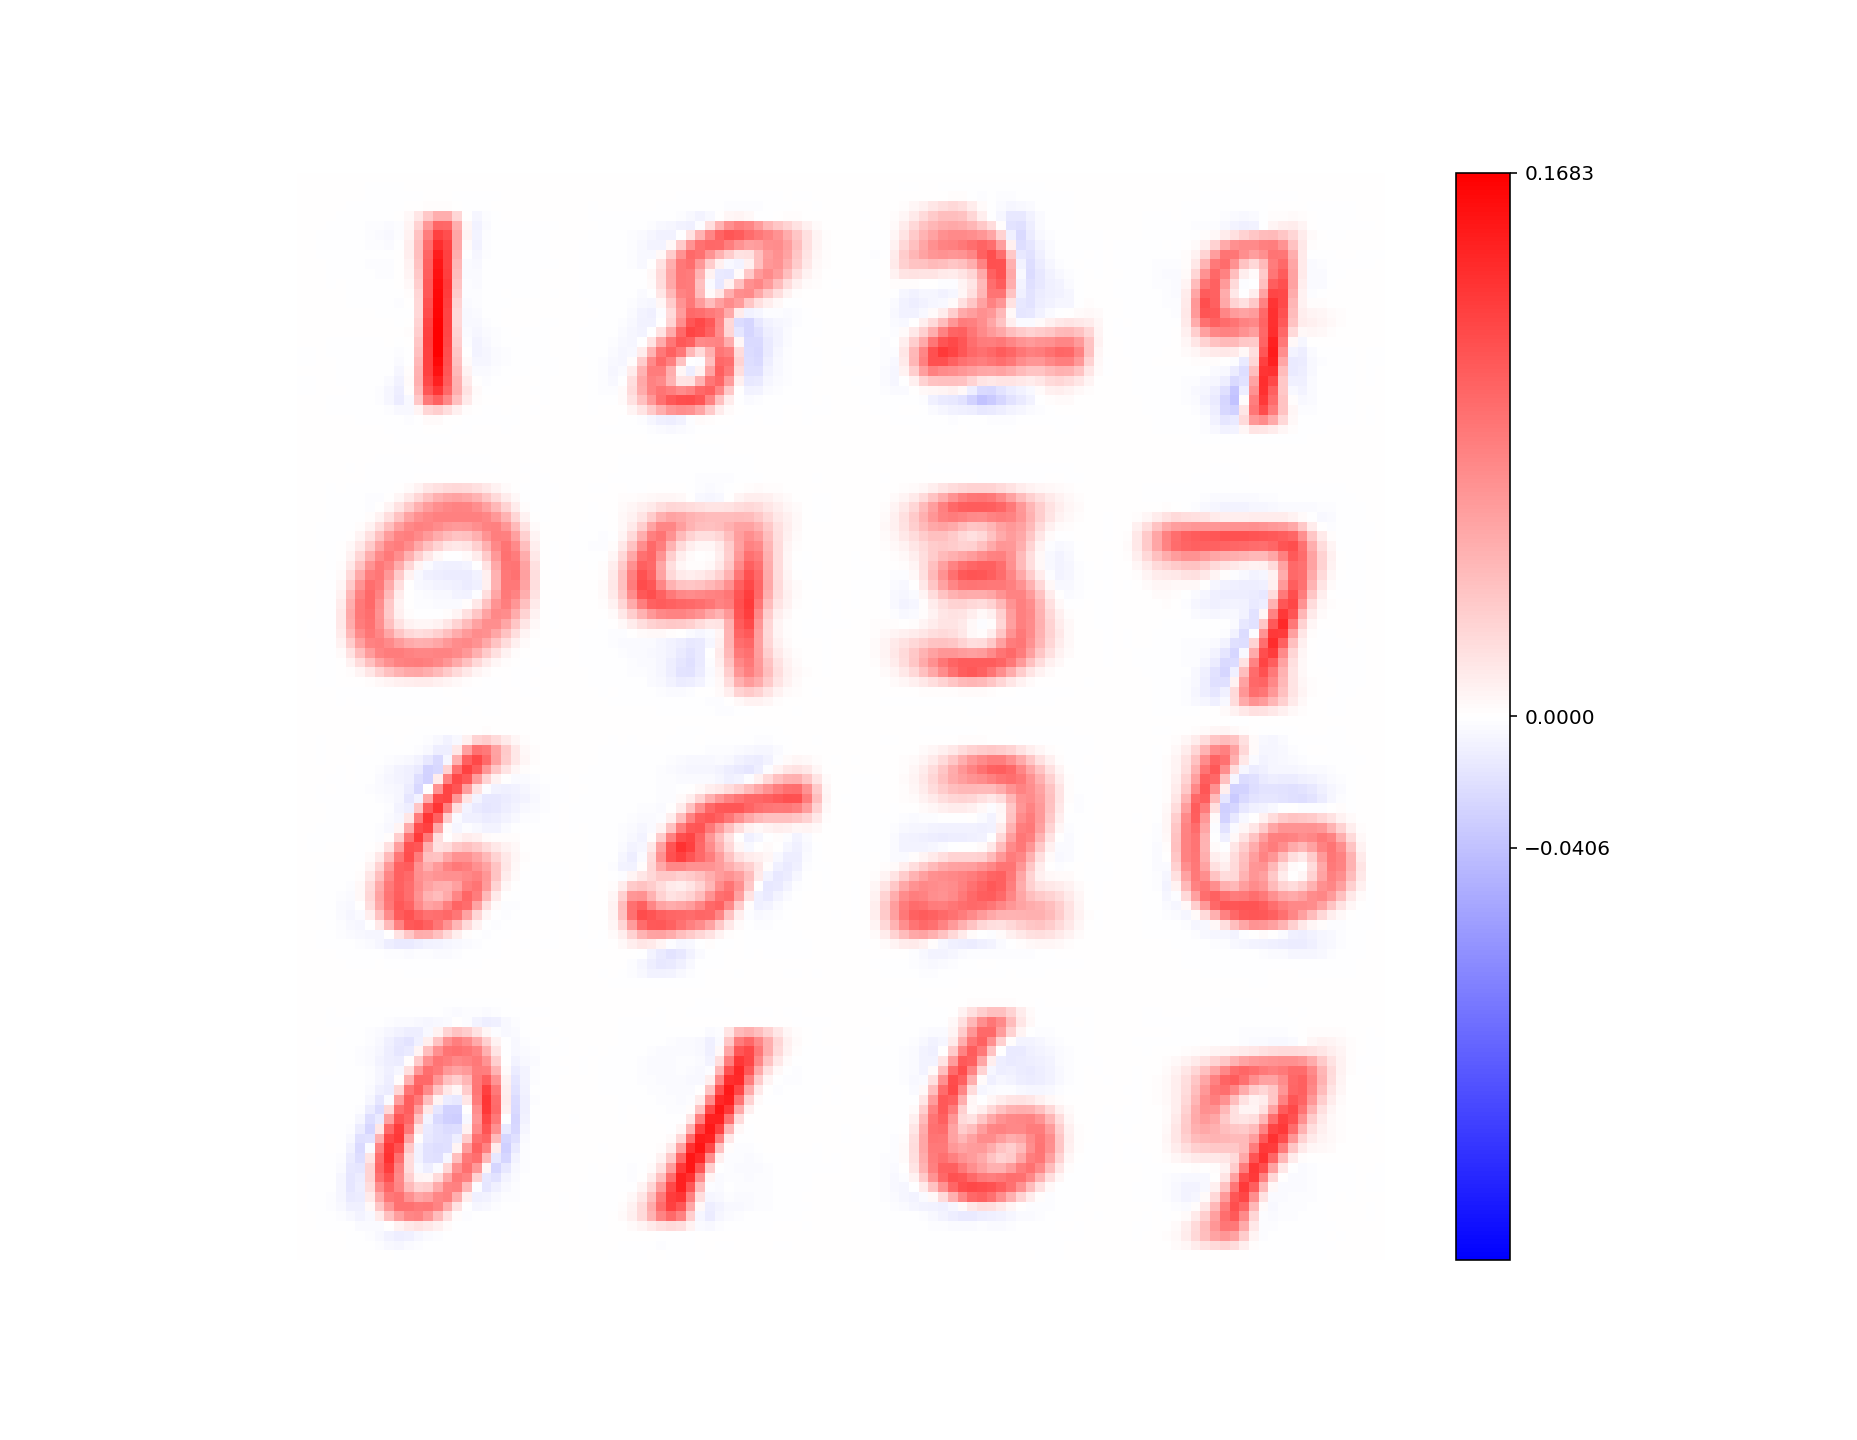

(16, 784)
-3.939204758242347 3.9572276253080627
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100
Epoch 101
Epoch 102
Epoch 103
Epoch 104
Epoch 105
Epoch 106


In [4]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12.9,10))

synapses = np.random.normal(mu, sigma, (hid, N))
print(synapses.shape)
print(np.min(synapses), np.max(synapses))

for nep in range(Nep):  # epochs
    print("Epoch {}".format(nep + 1))
    eps = eps0*(1-nep/Nep)
    M = M[np.random.permutation(Ns), :]
    
    for i in range(Ns // Num):  # minibatches
        inputs = np.transpose(M[i*Num:(i+1)*Num, :])
        # print(inputs.shape) -> (N, Num)
        sig = np.sign(synapses)
        tot_input = np.dot(sig * np.absolute(synapses)**(p-1), inputs)  # see formula [2], these are the currents
        
        y = np.argsort(tot_input, axis=0)  # fast implementation -> ranking of currents
        yl = np.zeros((hid, Num))  # activations of post synaptic cells, g(Q) in [3], see also [9] and [10]
        yl[y[hid - 1, :], np.arange(Num)] = 1.0  # see [10]
        yl[y[hid - k], np.arange(Num)] = -delta
        
        xx = np.sum(np.multiply(yl, tot_input), 1)
        # ds is the right hand side of eq [3]
        ds = np.dot(yl, np.transpose(inputs)) - np.multiply(np.tile(xx.reshape(xx.shape[0], 1), (1, N)), synapses)
        
        nc = np.amax(np.absolute(ds))
        if nc < prec:
            nc = prec
        synapses += eps * np.true_divide(ds, nc)
        
    draw_weights(synapses, Kx, Ky)
        